In [2]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    ExpSineSquared,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


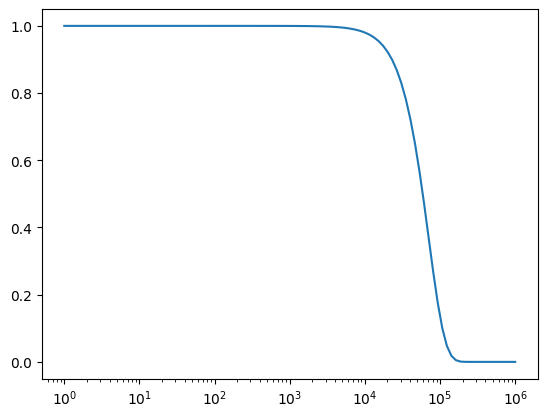

In [ ]:
X = np.logspace(0, 6, 100)
plt.plot(X, rbf(X, 5e4, 1.0))
plt.xscale("log")

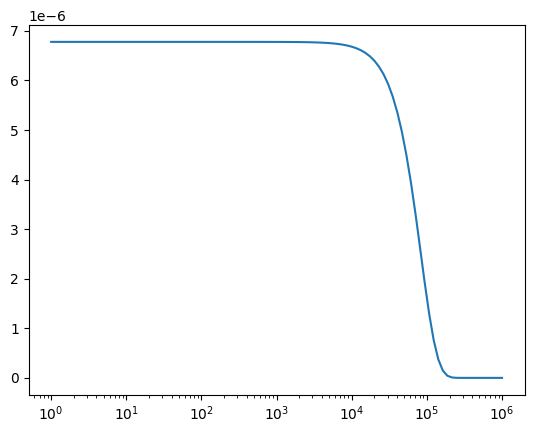

In [ ]:
X = np.logspace(0, 6, 100)
plt.plot(X, gaussian(X, 0, 2.355 * 2.5e4))
plt.xscale("log")

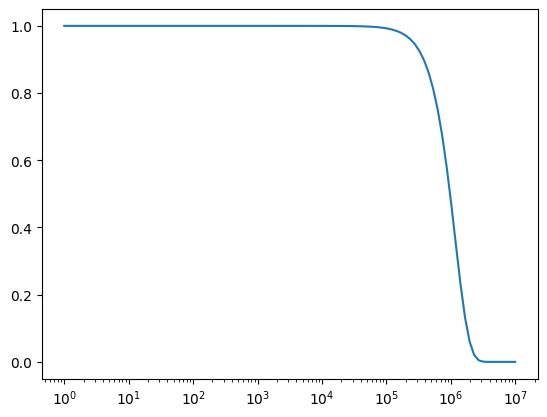

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, rbf(X, 8.28e5, 1.0))
plt.xscale("log")

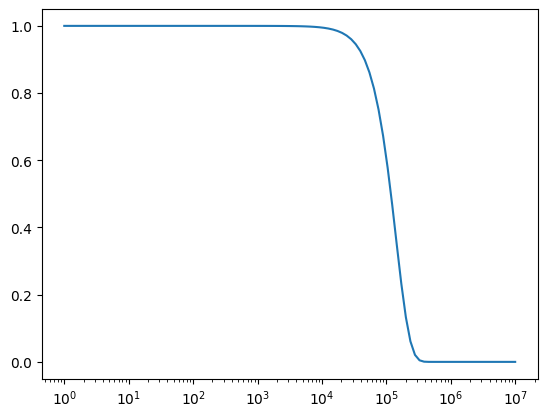

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, rbf(X, 1e5, 1.0))
plt.xscale("log")

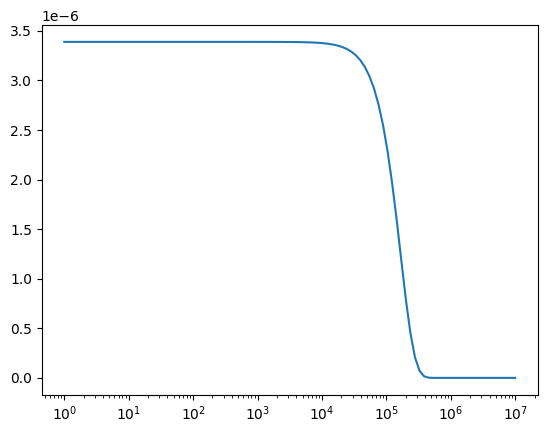

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, gaussian(X, 0, 2.355 * 5e4))
plt.xscale("log")

In [ ]:
gp = pickle.load(open(f"./models/world.pkl", "rb"))

In [ ]:
gp.kernel_

1.12**2 * RBF(length_scale=[8.28e+05, 6.14e+05]) + WhiteKernel(noise_level=1.18)

In [12]:
from utils import *
from map_utils import *
from models import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import TransformedTargetRegressor

In [21]:
region = 'germany'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
 Training RMSE: 39.47403124630482
 Training MAE: 22.822391431585412
 Validation RMSE: 40.637551940683906
 Validation MAE: 23.710596308405364

Loading country shapes...
Transforming heatmap...
max map waiting time: 70.42445561479886
min map waiting time: -1.0
Plotting heatmap...
max waiting time: 675


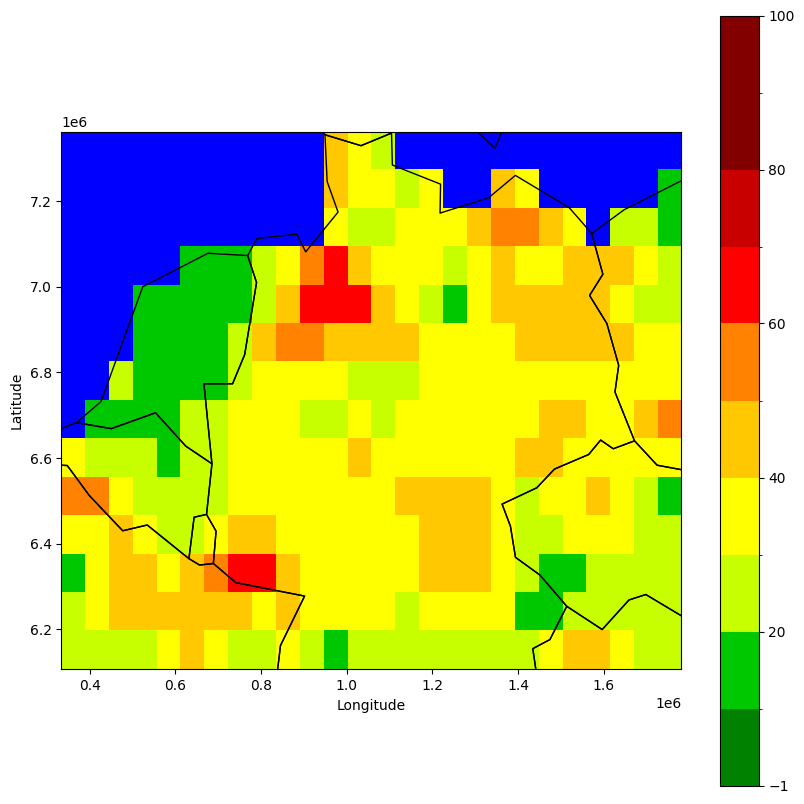

In [22]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
 Training RMSE: 41.700716722506705
 Training MAE: 24.692506681672775
 Validation RMSE: 41.47687241204024
 Validation MAE: 24.692529457136537



100%|██████████| 130/130 [00:00<00:00, 79183.78it/s]

Loading country shapes...


Transforming heatmap...
max map waiting time: 31.49387708992318
min map waiting time: 31.49387708992318
Plotting heatmap...
max waiting time: 675


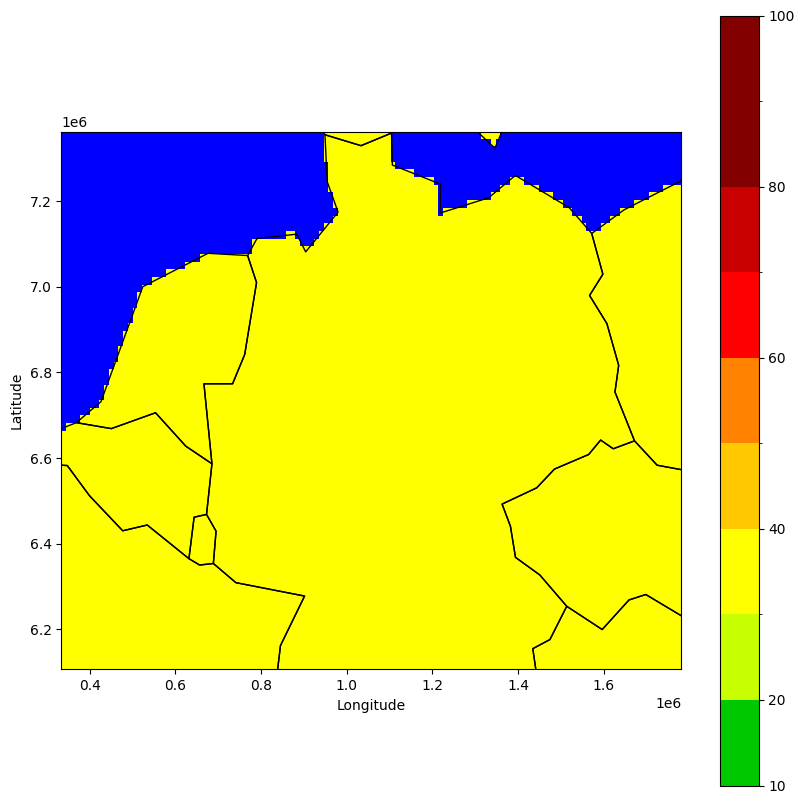

In [23]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 40.993822365353665
 Training MAE: 24.053454534454843
 Validation RMSE: 41.15913591352587
 Validation MAE: 24.329956706206097



  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [00:00<00:00, 5801.87it/s]

Loading country shapes...


Transforming heatmap...
max map waiting time: 94.16666666666667
min map waiting time: 0.0
Plotting heatmap...
max waiting time: 675


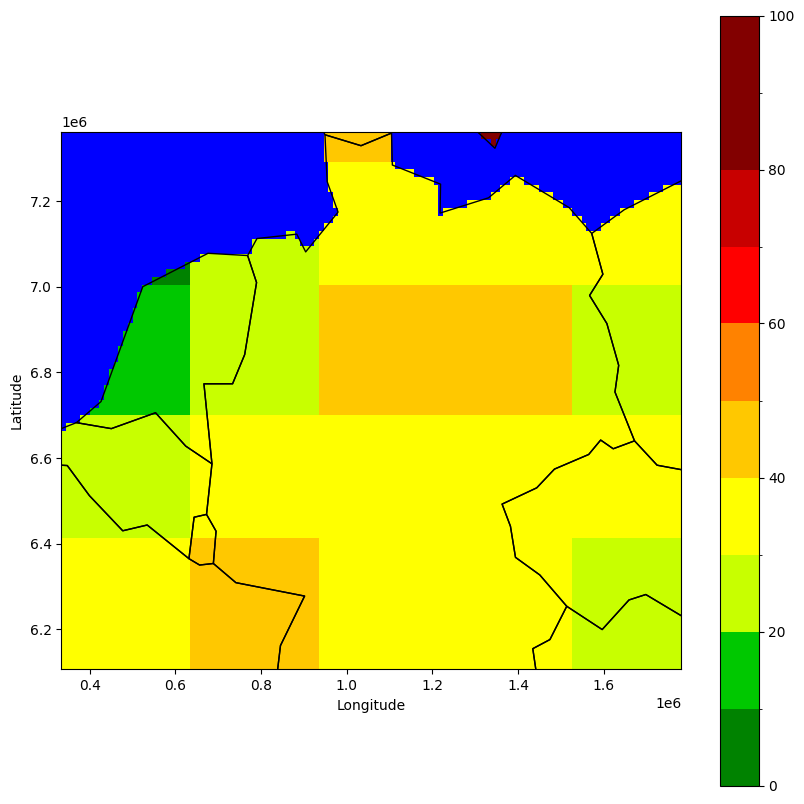

In [24]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 42.12016713005924
 Training MAE: 20.766190235726413
 Validation RMSE: 42.27439273654638
 Validation MAE: 21.140799942290375

0.97**2 * RBF(length_scale=[2.16e+05, 1.64e+05]) + WhiteKernel(noise_level=0.841)


100%|██████████| 130/130 [00:03<00:00, 33.71it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 40.55229078450901
min map waiting time: 9.462005148365767
Plotting heatmap...
max waiting time: 675


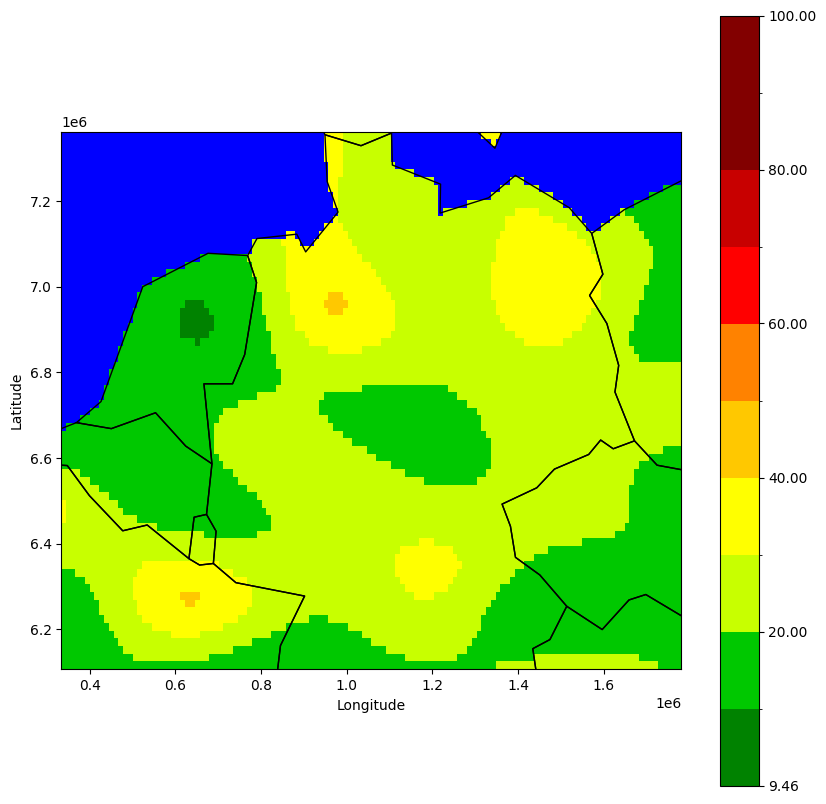

In [27]:
X = points[["lon", "lat"]].values
y = points["wait"].values


log_transformer = get_log_transformer()
y_transformed = log_transformer.fit_transform(y)

sigma = np.std(y_transformed)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * RBF(
    length_scale=[1e5, 1e5],
    length_scale_bounds=[(1e4, 1e6), (1e4, 1e6)],
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_gpr(kernel)
gpr = evaluate_cv(estimator=gpr, X=X, y=y)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)